## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
from keras.callbacks import ModelCheckpoint

model_ckpt1 = ModelCheckpoint(filepath="./tmp1.h5", 
                             monitor="val_loss", 
                             save_best_only=False)

In [11]:
model1 = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model1.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model1.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt1]
         )

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512 

Epoch 46/50
50000/50000 [==============================] - 11s 210us/step - loss: 0.5580 - accuracy: 0.8356 - val_loss: 1.6368 - val_accuracy: 0.4837
Epoch 47/50
50000/50000 [==============================] - 11s 213us/step - loss: 0.5409 - accuracy: 0.8432 - val_loss: 1.6432 - val_accuracy: 0.4844
Epoch 48/50
50000/50000 [==============================] - 11s 217us/step - loss: 0.5216 - accuracy: 0.8504 - val_loss: 1.6517 - val_accuracy: 0.4898
Epoch 49/50
50000/50000 [==============================] - 11s 222us/step - loss: 0.5072 - accuracy: 0.8571 - val_loss: 1.6935 - val_accuracy: 0.4800
Epoch 50/50
50000/50000 [==============================] - 11s 220us/step - loss: 0.4907 - accuracy: 0.8618 - val_loss: 1.6902 - val_accuracy: 0.4821


KeyError: 'acc'

In [13]:
# Collect results
train_loss = model1.history.history["loss"]
valid_loss = model1.history.history["val_loss"]
train_acc = model1.history.history["accuracy"]
valid_acc = model1.history.history["val_accuracy"]

# Load back
model1 = keras.models.load_model("./tmp1.h5")
loss_loadback, acc_loadback = model1.evaluate(x_test, y_test)

10000/10000 [==============================] - 3s 279us/step


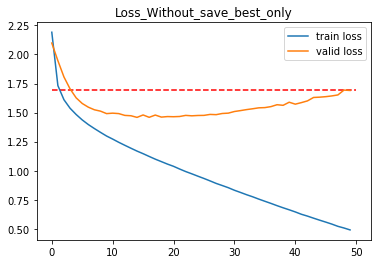

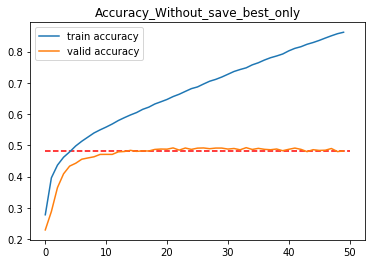

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss_Without_save_best_only")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy_Without_save_best_only")
plt.show()

In [15]:
model_ckpt2 = ModelCheckpoint(filepath="./tmp2.h5", 
                             monitor="val_loss", 
                             save_best_only=True,
                             save_weights_only=True)

In [23]:
model2 = build_mlp(input_shape=x_train.shape[1:])
model2.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model2.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt2]
         )

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512 

Epoch 46/50
50000/50000 [==============================] - 11s 212us/step - loss: 0.5720 - accuracy: 0.8330 - val_loss: 1.6480 - val_accuracy: 0.4863
Epoch 47/50
50000/50000 [==============================] - 11s 221us/step - loss: 0.5557 - accuracy: 0.8388 - val_loss: 1.6539 - val_accuracy: 0.4810
Epoch 48/50
50000/50000 [==============================] - 11s 222us/step - loss: 0.5391 - accuracy: 0.8459 - val_loss: 1.6565 - val_accuracy: 0.4888
Epoch 49/50
50000/50000 [==============================] - 12s 250us/step - loss: 0.5228 - accuracy: 0.8524 - val_loss: 1.6801 - val_accuracy: 0.4806
Epoch 50/50
50000/50000 [==============================] - 13s 256us/step - loss: 0.5051 - accuracy: 0.8582 - val_loss: 1.6950 - val_accuracy: 0.4825


In [24]:
# Collect results
train_loss = model2.history.history["loss"]
valid_loss = model2.history.history["val_loss"]
train_acc = model2.history.history["accuracy"]
valid_acc = model2.history.history["val_accuracy"]

# Load back
model2_1 = model2.load_weights("./tmp2.h5")
loss_loadback, acc_loadback = model2_1.evaluate(x_test, y_test)

AttributeError: 'NoneType' object has no attribute 'evaluate'

In [ ]:
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss_With_save_weights_only")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy_With_save_weights_only")
plt.show()

### Reset ipynb